<span style="color: rgb(112, 112, 112);">**in the name of God**</sapn>

---

# <span style="color: rgb(112, 112, 112);">**Task 3: LLM for MCQs**</sapn>

# <span style="color: rgb(85, 186, 226);">**Hugging face access token**</sapn>

In [ ]:
from huggingface_hub import login

login(token="Enter")

# <span style="color: rgb(85, 186, 226);">**Loading the dataset**</sapn>

In [ ]:
from datasets import load_dataset
import pandas as pd

swag_dataset = load_dataset('swag')

# <span style="color: rgb(85, 186, 226);">**Analyse the dataset**</sapn>

In [4]:
train_df = swag_dataset.get('train').to_pandas()
valid_df = swag_dataset.get('validation').to_pandas()
test_df = swag_dataset.get('test').to_pandas()
df = pd.concat([train_df, valid_df, test_df])

In [5]:
print(f"train set size: {len(train_df)/1000}k")
print(f"validation set size: {len(valid_df)/1000}k")
print(f"test set size: {len(test_df)/1000}k")

train set size: 73.546k
validation set size: 20.006k
test set size: 20.005k


In [6]:
df.head()

,video-id,fold-ind,startphrase,sent1,sent2,gold-source,ending0,ending1,ending2,ending3,label
0,anetv_jkn6uvmqwh4,3416,Members of the procession walk down the street...,Members of the procession walk down the street...,A drum line,gold,passes by walking down the street playing thei...,has heard approaching them.,arrives and they're outside dancing and asleep.,turns the lead singer watches the performance.,0
1,anetv_jkn6uvmqwh4,3417,A drum line passes by walking down the street ...,A drum line passes by walking down the street ...,Members of the procession,gen,are playing ping pong and celebrating one left...,wait slowly towards the cadets.,continues to play as well along the crowd alon...,"continue to play marching, interspersed.",3
2,anetv_jkn6uvmqwh4,3415,A group of members in green uniforms walks wav...,A group of members in green uniforms walks wav...,Members of the procession,gold,pay the other coaches to cheer as people this ...,walk down the street holding small horn brass ...,is seen in the background.,are talking a couple of people playing a game ...,1
3,anetv_jkn6uvmqwh4,3417,A drum line passes by walking down the street ...,A drum line passes by walking down the street ...,Members of the procession,gen,are playing ping pong and celebrating one left...,wait slowly towards the cadets.,makes a square call and ends by jumping down i...,play and go back and forth hitting the drums w...,3
4,anetv_Bri_myFFu4A,2408,The person plays a song on the violin. The man,The person plays a song on the violin.,The man,gold,finishes the song and lowers the instrument.,hits the saxophone and demonstrates how to pro...,finishes massage the instrument again and cont...,continues dancing while the man gore the music...,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113557 entries, 0 to 20004
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   video-id     113557 non-null  object
 1   fold-ind     113557 non-null  object
 2   startphrase  113557 non-null  object
 3   sent1        113557 non-null  object
 4   sent2        113557 non-null  object
 5   gold-source  113557 non-null  object
 6   ending0      113557 non-null  object
 7   ending1      113557 non-null  object
 8   ending2      113557 non-null  object
 9   ending3      113557 non-null  object
 10  label        113557 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 10.4+ MB


In [8]:
df.isnull().sum()

,0
video-id,0
fold-ind,0
startphrase,0
sent1,0
sent2,0
gold-source,0
ending0,0
ending1,0
ending2,0
ending3,0


In [9]:
df.duplicated().sum()

np.int64(0)

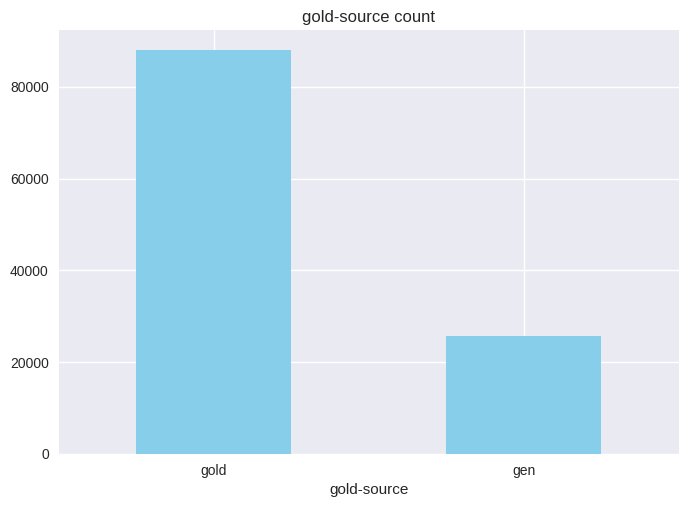

In [10]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

source_count = df['gold-source'].value_counts()

source_count.plot(kind='bar', title='gold-source count', color='skyblue')
plt.xticks(rotation=0)
plt.show()

In [11]:
df_v2 = df.copy()
df_v2['len_sent1'] = df_v2['sent1'].apply(lambda x: len(x.split()))
df_v2['len_sent2'] = df_v2['sent2'].apply(lambda x: len(x.split()))
df_v2['len_end0'] = df_v2['ending0'].apply(lambda x: len(x.split()))
df_v2['len_end1'] = df_v2['ending1'].apply(lambda x: len(x.split()))
df_v2['len_end2'] = df_v2['ending2'].apply(lambda x: len(x.split()))
df_v2['len_end3'] = df_v2['ending3'].apply(lambda x: len(x.split()))

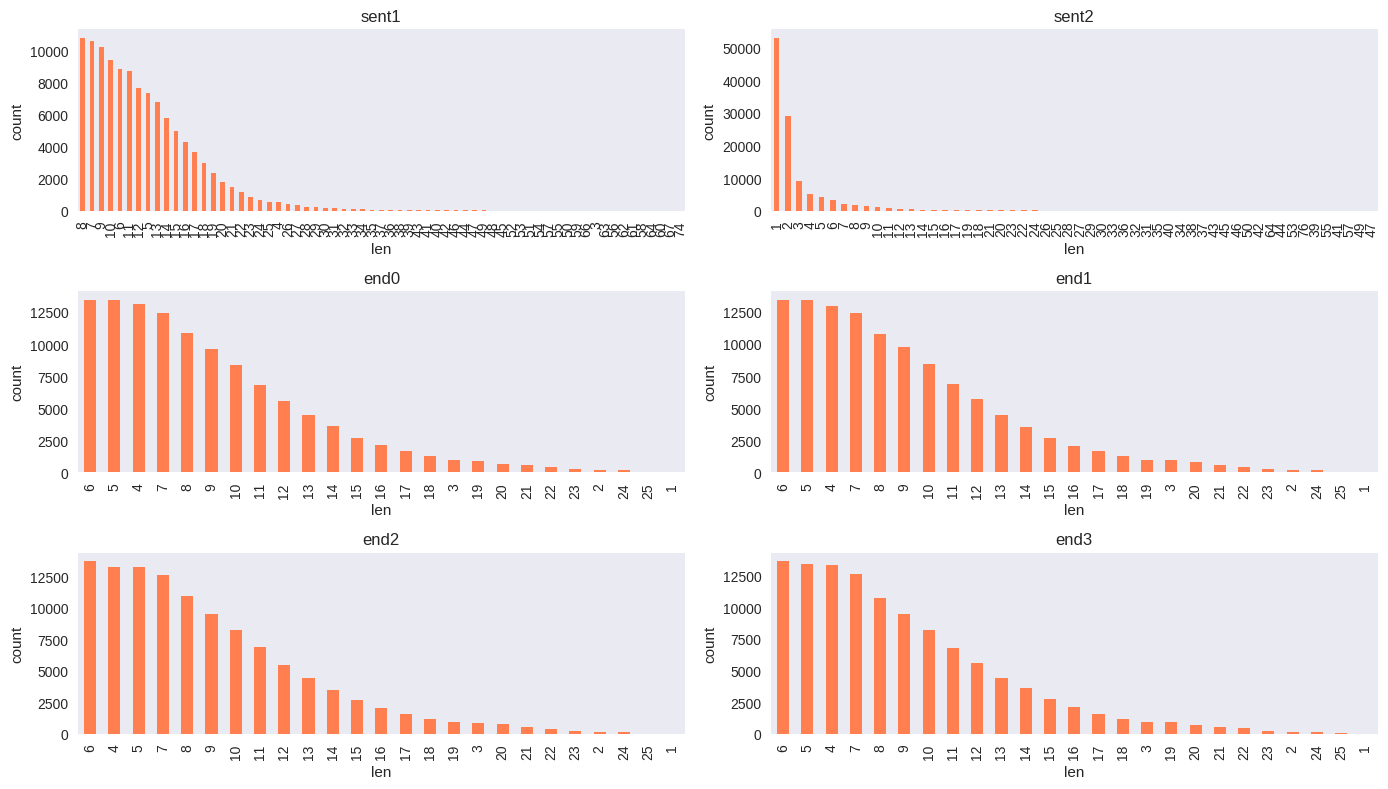

In [12]:
len_columns = ['len_sent1', 'len_sent2', 'len_end0', 'len_end1', 'len_end2', 'len_end3']

plt.figure(figsize=(14, 8))

for i, col in enumerate(len_columns, 1):
    plt.subplot(3, 2, i)
    ax = df_v2[col].value_counts().plot(kind='bar', color='coral', grid=False)
    plt.title(col.split('_')[1])
    plt.xlabel('len')
    plt.ylabel('count')

plt.tight_layout()
plt.show()

In [13]:
df_v2[len_columns].describe()

,len_sent1,len_sent2,len_end0,len_end1,len_end2,len_end3
count,113557.000000,113557.000000,113557.000000,113557.000000,113557.000000,113557.000000
mean,11.538082,2.700617,8.667119,8.690068,8.660320,8.651461
std,5.382825,3.147949,4.009486,4.021567,4.018033,4.018416
min,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,8.000000,1.000000,6.000000,6.000000,6.000000,6.000000
50%,10.000000,2.000000,8.000000,8.000000,8.000000,8.000000
75%,14.000000,3.000000,11.000000,11.000000,11.000000,11.000000
max,74.000000,76.000000,25.000000,25.000000,25.000000,25.000000


# <span style="color:rgb(85, 186, 226);">**Preprocess the dataset**</sapn>

In [14]:
def preprocess(batch: dict, tokenizer):
    batch_size = len(batch['sent1'])
    all_candidates = []
    for i in range(batch_size):
        full_sentence = batch['sent1'][i] + ' ' + batch['sent2'][i]
        for k in range(4):
            candidate = full_sentence + ' ' + batch[f"ending{k}"][i]
            all_candidates.append(candidate)

    tokenized = tokenizer(all_candidates, return_tensors=None, truncation=True, max_length=128)

    def unflatten(lst):
        return [lst[i*4: (i+1)*4] for i in range(batch_size)]

    tokenized = {k: unflatten(v) for k, v in tokenized.items()}

    tokenized["label"] = batch["label"]

    return tokenized

# <span style="color:rgb(85, 186, 226);">**Load a tokenizer**</sapn>


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

# <span style="color:rgb(85, 186, 226);">**Apply the preprocessing function**</sapn>

In [ ]:
train_dataset = swag_dataset['train']

preprocessed_trainset = train_dataset.map(lambda batch: preprocess(batch, tokenizer), batched=True)

# <span style="color:rgb(85, 186, 226);">**Padding**</sapn>

In [17]:
from transformers import DataCollatorForMultipleChoice

data_collator = DataCollatorForMultipleChoice(tokenizer, padding=True)

# <span style="color:rgb(85, 186, 226);">**Load the model**</sapn>

In [ ]:
from transformers import AutoModelForMultipleChoice

model = AutoModelForMultipleChoice.from_pretrained("google-bert/bert-base-uncased")

# <span style="color: rgb(85, 186, 226);">**Test the model on the dataset**</sapn>

## <span style="color: rgb(24, 66, 94);">**Test Case Analysis**</sapn>

In [19]:
import torch

sample = swag_dataset['validation'][491]
ground_truth_label = sample['label']

input_batch = {k: [v] for k, v in sample.items()}
preprocessed_sample = preprocess(input_batch, tokenizer)

collated_inputs = data_collator([
    {key: preprocessed_sample[key][0] for key in preprocessed_sample}
])

with torch.no_grad():
  outputs = model(**collated_inputs)

logits = outputs.logits
predicted_index = torch.argmax(logits, dim=1).item()

if predicted_index == ground_truth_label:
  print("The prediction of model is correct.\n")
else:
  print("The prediction of model is incorrect.\n")

ground_truth_sentence = sample["sent1"] + ' ' + sample["sent2"] + ' ' + sample[f"ending{ground_truth_label}"]
predicted_sentence = sample["sent1"] + ' ' + sample["sent2"] + ' ' + sample[f"ending{predicted_index}"]

print(f"Ground truth full sentence:\n{ground_truth_sentence}\n")
print(f"predicted full sentence:\n{predicted_sentence}")


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


The prediction of model is incorrect.

Ground truth full sentence:
The men play rock paper scissors. A lady in the crowd jumps up and down.

predicted full sentence:
The men play rock paper scissors. A lady in the crowd claps with a paper trophy.


## <span style="color: rgb(24, 66, 94);">**Comprehensive Validation Set Evaluation**</sapn>

In [ ]:
validation_dataset = swag_dataset["validation"]
preprocessed_validation_set = validation_dataset.map(lambda batch: preprocess(batch, tokenizer), batched=True)

In [ ]:
import evaluate
import numpy as np

accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=1)
  return accuracy_metric.compute(predictions=predictions, references=labels)

In [22]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    per_device_eval_batch_size=32,
    output_dir='./results'
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=preprocessed_validation_set,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [ ]:
results = trainer.evaluate()

In [112]:
final_accuracy = results['eval_accuracy']
print(f"Number of validation examples: {len(preprocessed_validation_set)}")
print(f"Validation Accuracy: {final_accuracy*100:.2f}%")

Number of validation examples: 20006
Validation Accuracy: 26.20%


## <span style="color: rgb(24, 66, 94);">**Baseline with vlidation split**</sapn>

In [ ]:
swag_dataset = load_dataset("swag")
validation_spilt = swag_dataset['validation'].select(range(500))
preprocessed_validation_split = validation_spilt.map(lambda batch: preprocess(batch, tokenizer), batched=True)

training_args = TrainingArguments(
    per_device_eval_batch_size=32,
    output_dir='./results_validation_split'
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=preprocessed_validation_split,
    data_collator=data_collator,
    compute_metrics=compute_metrics

)

results = trainer.evaluate()
baseline_bert_accuracy = results['eval_accuracy']

# <span style="color: rgb(85, 186, 226);">**Use in-context learning (ICL)**</sapn>

## <span style="color: rgb(24, 66, 94);">**evaluation function**</sapn>

In [98]:
from tqdm import tqdm
import torch

def evaluate_method(prompt_constructor, dataset, tokenizer,
                        device):
    correct_pred = 0
    length_ds = len(dataset)

    for i in tqdm(range(length_ds), desc=f"Evaluating {prompt_constructor.__name__}"):
        sample = dataset[i]

        context = sample['sent1'] + ' ' + sample['sent2']
        options = [sample[f"ending{k}"] for k in range(4)]
        ground_truth_label = options[sample['label']]

        prompt = prompt_constructor(context, options)

        inputs = tokenizer(prompt, return_tensors="pt").to(device)


        with torch.no_grad():
            outputs = model.generate(
              **inputs,
              max_new_tokens=150,
              temperature=0.0
            )

        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        if ground_truth_label.lower() in generated_text.lower():
          correct_pred +=1

    return correct_pred / length_ds

In [99]:
from transformers import T5ForConditionalGeneration

MODEL_ID = "google/flan-t5-large"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

toeknizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = T5ForConditionalGeneration.from_pretrained(MODEL_ID).to(device)

swag_dataset = load_dataset("swag")
validation_spilt = swag_dataset['validation'].select(range(500))

Using device: cuda


## <span style="color: rgb(24, 66, 94);">**technique 1: few-shot**</sapn>

In [102]:
FEW_SHOT_EXAMPLES = [
    {
        "context": "A woman is outside with a bucket and a dog. The dog is running around the yard.",
        "options": [
            "The dog jumps into a small kiddie pool to cool off.",
            "The woman sits on the porch to read a book.",
            "The dog is running around the yard, wagging its tail happily.",
            "A cat appears from behind the fence and stares at the dog."
        ],
        "answer": "The dog is running around the yard, wagging its tail happily."
    },
    {
        "context": "A man is in a kitchen making sandwiches. He cuts a sandwich in half.",
        "options": [
            "He places each half on a separate plate for serving.",
            "He wraps the sandwich in foil and puts it in the fridge.",
            "He leaves the sandwich halves on the counter unattended.",
            "He puts the halves back together and stores them in a container."
        ],
        "answer": "He places each half on a separate plate for serving."
    }
]


In [103]:
def get_format_options(options: list):
	return '\n'.join([f"- {opt}" for opt in options])

def construct_few_shot_prompt(context: str, options: list):
	prompt = "Choose the most logical and plausible continuation for the given context from the options provided.\n\n"

	for example in FEW_SHOT_EXAMPLES:
		prompt += f"Context: {example['context']}\n"
		prompt += f"Options:\n{get_format_options(example['options'])}\n"
		prompt += f"Answer: {example['answer']}\n\n"

	prompt += "---\n"
	prompt += f"Context: {context}\n"
	prompt += f"Options:\n{get_format_options(options)}\n"
	prompt += "Answer:"

	return prompt

In [104]:
few_shot_accuracy = evaluate_method(
    prompt_constructor=construct_few_shot_prompt,
    dataset=validation_spilt,
    tokenizer=tokenizer,
    device=device
)

Evaluating construct_few_shot_prompt: 100%|██████████| 500/500 [05:29<00:00,  1.52it/s]


## <span style="color: rgb(24, 66, 94);">**technique 2: zero-shot**</sapn>

In [110]:
def construct_zero_shot_prompt(context: str, options: list):
	prompt = "Choose the most logical and plausible continuation for the given context from the options provided.\n\n"

	prompt += f"Context: {context}\n"
	prompt += f"Options:\n{get_format_options(options)}\n"
	prompt += "Let's think step by step. After reasoning, provide the final answer as."

	return prompt

In [111]:
zeroshot_cot_accuracy = evaluate_method(
    prompt_constructor=construct_zero_shot_prompt,
    dataset=validation_spilt,
    tokenizer=tokenizer,
    device=device
)

Evaluating construct_zero_shot_prompt:  76%|███████▋  | 382/500 [03:26<00:53,  2.21it/s]The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Evaluating construct_zero_shot_prompt: 100%|██████████| 500/500 [04:30<00:00,  1.85it/s]


## <span style="color: rgb(24, 66, 94);">**Results**</sapn>

In [113]:
print(f"Evaluated on {len(validation_spilt)} samples.")
print(f"Baseline Accuracy: {baseline_bert_accuracy * 100:.2f}%")
print(f"Few-Shot ICL Accuracy: {few_shot_accuracy*100:.2f}%")
print(f"Zero-Shot CoT Accuracy: {zeroshot_cot_accuracy*100:.2f}%")

Evaluated on 500 samples.
Baseline Accuracy: 26.20%
Few-Shot ICL Accuracy: 68.40%
Zero-Shot CoT Accuracy: 65.80%


# <span style="color:rgb(85, 186, 226);">**Fine-tune bert**</sapn>

# <span style="color:rgb(85, 186, 226);">**In-Context Learning with the Fine-Tuned Model**</sapn>

# <span style="color:rgb(85, 186, 226);">**Analyse the results**</sapn>

# <span style="color:rgb(238, 65, 65);">**Questions**</sapn>